# Introduction to `gpvolve`

In [1]:
# Import gpvolve functions explicitly.
from gpvolve import GenotypePhenotypeMSM
from gpvolve.fitness import one_to_one
from gpvolve.fixation import mccandlish
from gpvolve.flux import TransitionPathTheory
from gpvolve.visualization import plot_network, plot_matrix
from gpvolve.paths import flux_decomp
from gpvolve.utils import *
from gpvolve.cluster.pcca import PCCA
from gpvolve.cluster.base import GenotypePhenotypeClusters
from gpvolve.cluster.utils import *
from gpvolve.analysis.pathways import *

In [2]:
# Import gpmap for genotype-phenotype data handling
from gpmap.simulate import MultiPeakMountFujiSimulation, MountFujiSimulation

In [3]:
# Helper and plotting functions.
import matplotlib.pyplot as plt
from scipy.sparse import dok_matrix
import pickle

## Load data

Simulate 7-site map with 4 fitness peaks and then create a `GenotypePhenotypeMSM` object, which is the class used for building and analyzing a markov state model. 

You can also import exisiting genotype-phenotype data here. See the gpmap Python package for more information (https://github.com/harmslab/gpmap)

In [4]:
gpm = MultiPeakMountFujiSimulation.from_length(7, peak_n=4, min_dist=2, roughness_width=0.2, field_strength=1)

evomsm = GenotypePhenotypeMSM(gpm)

## Build Markov model

First we need to map a fitness value onto each phenotype. In this example we simple use phenotype values as fitnesses. The user can also pass their own fitness function here.

In [5]:
evomsm.apply_selection(one_to_one)

Building the transition matrix requires the user to define a fixation probability function and all its required parameteres. Here, we use the fitness function by McCandlish (McCandlish, 2011) and a population size of 10.

In [6]:
evomsm.build_transition_matrix(mccandlish, population_size=10)

## Transition Path Theory

Having built an evolutionary Markov model of the genotype-phenotype map, we can use Transition Path Theory to compute reactive flux that moves from the wild type to the 7-site mutant.

In [7]:
# Compute reactive flux between wild type and 7-site mutant.
tpt = TransitionPathTheory(evomsm, [0], [127])

Now we can use the reactive flux to compute the pathways that go from genotype 0 (0000000) to 127 (1111111) and their relative probabilities.

In [8]:
paths = tpt.ReactiveFlux.pathways()

## Visualize Transition Path Theory output

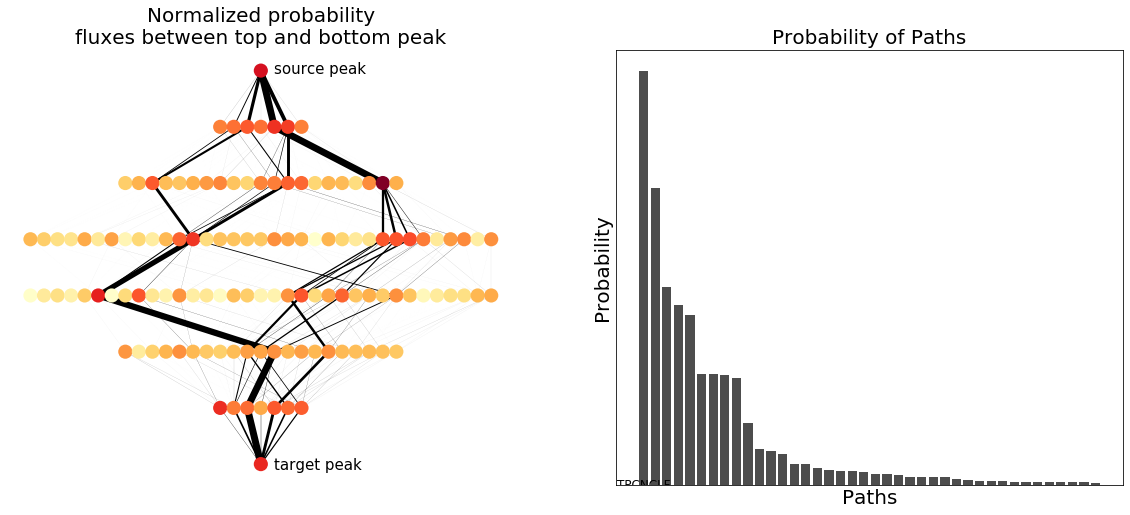

In [9]:
# Sort path probabilities
path_probabilitities = sorted(paths[1], reverse=True)

# Normalize all paths with probability > 0.001.
prob_sum = sum(path_probabilitities)
norm_path_probabilities = [prob/prob_sum for prob in path_probabilitities if prob/prob_sum > 0.001]
x = range(len(norm_path_probabilities))

# Draw figure
figsize=(20,8)
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=figsize)

# Plot genotype-phenotype map as network.
plot_network(evomsm, ax=ax1, figsize=figsize, node_size=200, flux=dok_matrix(tpt.net_flux/tpt.total_flux))

ax1.set_title("Normalized probability\nfluxes between top and bottom peak", size=20)
ax1.text(1,-0.05, "source peak", size=15)
ax1.text(1,-7.1, "target peak", size=15)

# Plot the probabilities of the most likely paths.
ax2.bar(x, norm_path_probabilities, color='0.3')

ax2.set_xlabel("Paths", size=20)
ax2.set_ylabel("Probability", size=20)
ax2.set_title("Probability of Paths", size=20)

plt.show()

## Coarse-grain genotype-phenotype map using PCCA+.
#### If you are using Windows & get an error, try rerunning the cell three times in a row, the error will go away.

Next, we use Robust Perron-Cluster Cluster Analysis (PCCA+) to coarse-grain the genotype-phenotype map.

In [10]:
# Cluster genotype-phenotype map into 4 clusters.
pcca = PCCA(evomsm, 4)

Since PCCA+ might not return the 4 clusters in the order that we prefer, we have to reorder the clusters.

In [11]:
# Find peaks and order them.
peaks = sorted([list(peak)[0] for peak in evomsm.peaks()])

# Reorder the pcca clusters according to the peak they contain.
ord_clusters = sort_clusters_by_nodes(pcca.clusters, peaks)

# We simply instantiate a new object for the newly sorted clusters
clustering = GenotypePhenotypeClusters(evomsm, ord_clusters)

In [12]:
# Memberships won't be in order but can be reordered using the command below
reordered_row = pcca.memberships[clustering.order, :]
reordered_mem = reordered_row[:, [0,1,2,3]]
clustering.memberships = reordered_mem

In [13]:
# Check if sorting was correct by finding the peak in each cluster.
string = ""
for i, cluster in enumerate(clustering.clusters):
    for peak in peaks:
        if peak in cluster:
            string = string + "Cluster %s: %s (%s)\n" % (i, clustering.gpmsm.gpm.data.binary[peak], peak)
print(string)

Cluster 0: 0000000 (0)
Cluster 1: 0100111 (39)
Cluster 2: 1010000 (80)
Cluster 3: 1111111 (127)



## Visualize the metastability of the coarse-grained genotype-phenotype map.

If we plot the coarse transition matrix, we see that most of the transition probability is located at the diagonal, i.e. transitions that happen within a cluster are more likely than transitions between clusters. The colorbar on the right is in log10(transition probability).

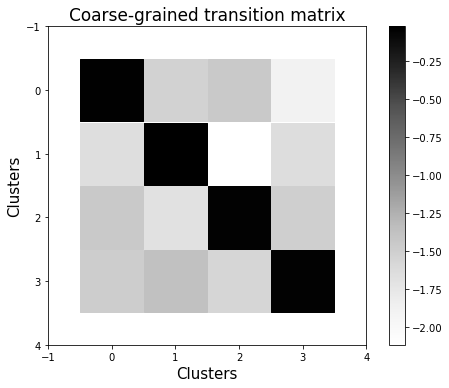

In [14]:
# Plot coarse-grained transition matrix.
fig, ax = plt.subplots(figsize=(7,5.5))
header = 17
ax_labels = 15

plot_matrix(clustering.transition_matrix, ax=ax, colorbar=True)
ax.set_title("Coarse-grained transition matrix", size=header)
ax.set_ylabel("Clusters", size=ax_labels)
ax.set_xlabel("Clusters", size=ax_labels)
ax.set_aspect("equal")

plt.tight_layout()

## Analyze evolutionary mechanisms along fitness peaks.

Finally, we can analyze evolutionary trajectories that pass genotypes of interest. In this example we will look at the trajectories that pass through peak 2 on their way to peak 4 (1-2-4). We split the trajectories into the part between peak 1 and 2 and the part between peak 2 and 4. We find that the sub-trajectories between 2 and 4 are much less constrained than the ones between 1 and 2, which we quantify by calculating the mean path divergence.

In [15]:
# First get normalized path probabilities as dict
path_probs = paths_and_probs_to_dict(paths[0], paths[1], normalize=True)
all_paths = list(path_probs.keys())

# Path 1-2-4
paths124 = paths_that_do_not_contain(paths_that_contain(all_paths, [0,14,127], bool_and=True), [101])
paths124_probs = {path: path_probs[path] for path in paths124}
mpd124 = mean_path_divergence(evomsm, paths124_probs)
entr124 = entropy(list(paths124_probs.values()))

## Segment 1-2
paths124_12 = get_sub_paths(paths124_probs, 0, 14)
mdp124_12 = mean_path_divergence(evomsm, paths124_12)
## Segment 2-4
paths124_24 = get_sub_paths(paths124_probs, 14, 127)
mdp124_24 = mean_path_divergence(evomsm, paths124_24)

print("Path\tPath count\tMean Path Divergence\n%s\t%s\t\t%s\n%s\t%s\t\t%s\n%s\t%s\t\t%s" % ("1-2", 
                                                                                            len(paths124_12), 
                                                                                            round(mdp124_12,2), 
                                                                                            "2-4", len(paths124_24), 
                                                                                            round(mdp124_24,2), 
                                                                                            "1-2-4", 
                                                                                            len(paths124), 
                                                                                            round(mpd124, 2)))


Path	Path count	Mean Path Divergence
1-2	6		0.0
2-4	6		0.0
1-2-4	9		0.0
